_This notebook contains code and comments from Section 9.3 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._


## 9.3. Black-Box Methods for Global Explainability
Methods for machine-learning model explainability can be categorized into two types:
- global methods attempt to generally explain a model’s decision-making process, and what factors are broadly relevant, while
- local methods attempt to specifically explain a model’s decision-making process with respect to individual examples and predictions.

Global explainability speaks to a model’s sensible behavior over a large number of examples when deployed or used in practice, while local explainability speaks to a model’s individual predictions on single examples that allow the user to make decisions on what to do next.

In [1]:
import pickle

with open('./data/ch09/bank_marketing_models.pickle', 'rb') as handle:
    models = pickle.load(handle)
    
with open('./data/ch09/bank_marketing_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

---
### 9.3.1. Permutation Feature Importance
Permutation feature importance calculates the feature importance scores by randomly permuting or shuffling the feature column and computing the change in some evaluation metric. The evaluation metric is ideally used on a held-out test set. This is a model agnostic method and can be applied to any machine-learning method.

The code snipped snippet below computes permutation feature importances for the XGBClassifier trained in the previous section using ``balanced_accuracy`` and ``recall``.

**Listing 9.5.** Computing Permutation Feature Importance

In [3]:
xgb = models['xgb']
Xtst = data['Xtst']
ytst = data['ytst']

from sklearn.inspection import permutation_importance
metrics = ['balanced_accuracy', 'recall']
pfi_scores = {}
for metric in metrics:
    print('Computing permutation importance with {0}...'.format(metric))
    pfi_scores[metric] = permutation_importance(xgb, Xtst, ytst, scoring=metric, n_repeats=30, random_state=7)

Computing permutation importance with balanced_accuracy...
Computing permutation importance with recall...


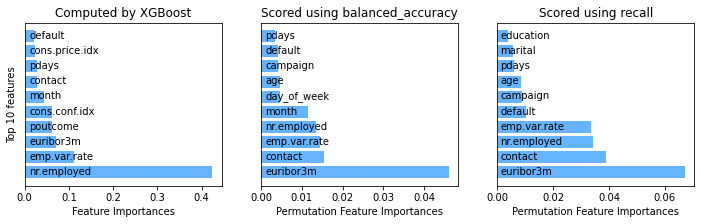

In [4]:
features = Xtst.columns.values
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

scores = xgb.feature_importances_
features = Xtst.columns.to_numpy()
srtd = np.argsort(-scores)

top = 10
ax[0].barh(y=np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha=0.6)
for i in range(top):
    ax[0].text(0.01, i-0.15, features[srtd[i]])
ax[0].set_yticks([])
ax[0].set_ylabel('Top {0} features'.format(top));
ax[0].set_xlabel('Feature Importances')
ax[0].set_title('Computed by XGBoost')

for k, metric in enumerate(metrics):
    scores = pfi_scores[metric]['importances_mean']
    srtd = np.argsort(-scores)
    
    ax[k+1].barh(y=np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha=0.6)
    for i in range(top):
        ax[k+1].text(0.001, i-0.15, features[srtd[i]])
    ax[k+1].set_yticks([])
    # ax[k+1].set_ylabel('Top {0} features scored with {1}'.format(top, metric));
    ax[k+1].set_xlabel('Permutation Feature Importances')
    ax[k+1].set_title('Scored using {0}'.format(metric))
    
pngFile = './figures/CH09_F08_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 9.3.2. Partial Dependence Plots
Partial dependence plots are another useful black-box approach, which help us identify the nature of the relationship between a feature and the target. 

Unlike permutation feature importance, which uses randomization to elicit the importance of a feature, the partial dependence relationship is identified using marginalization, or summing out. 

Partial dependence plots are intuitive to create and use, though can be somewhat time-consuming as new modified versions of the data set have to be created and evaluated for each point in the dependence plot. Here are some important technical details to keep in mind:
- Partial dependence tries to relate a model’s output to input features, that is, model behavior in terms of what it has learned. For this reason, it is best to create and visualize a partial dependence plot with the training set.
- Remember that a partial dependence function is created by averaging across n examples. That is to say, each training example results in an example-specific partial dependence function. The partial dependence between a specific example and its output is called the individual conditional expectation (ICE).

The example below illustrates how to construct partial dependence plots for the XGBoostClassifier trained in Section 9.2 on the bank marketing data set.

**Listing 9.6.** Creating partial dependence plots

In [5]:
Xtrn = data['Xtrn']
ytrn = data['ytrn']

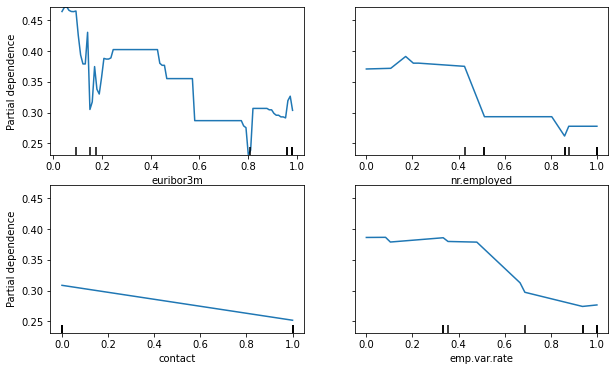

In [6]:
from sklearn.inspection import PartialDependenceDisplay as pdp
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
pdp.from_estimator(xgb, Xtrn, 
                   features=['euribor3m', 'nr.employed', 'contact', 'emp.var.rate'], 
                   feature_names=list(Xtrn.columns),
                   kind='average', response_method='predict_proba', 
                   ax=ax)
pngFile = './figures/CH09_F10_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 9.3.3. Global Surrogate Models
The idea of a surrogate model is extremely simple: we train a second model that mimics the behavior of the black-box model. However, the surrogate model itself is a glass box and inherently explainable. Once trained, we can use the surrogate glass-box model to explain the predictions of the black-box model. 

To train a useful surrogate model, we will need to find the sweet spot in the fidelity-interpretability tradeoff. This sweet spot will be a surrogate model that approximates the black-box’s predictions pretty well but is also not so complex that it defies any interpretation (possibly by inspection).

The figure below shows the fidelity-interpretability tradeoff for a decision-tree surrogate trained for the XGBoost model. The surrogate is trained on the same bank marketing training set that was used to train the XGBoost model in Section 9.1.

In [7]:
xgb = models['xgb']
Xtrn = data['Xtrn']
ytrn = data['ytrn']
Xtst = data['Xtst']
ytst = data['ytst']

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score

yb_trn_pred = xgb.predict(Xtrn)  # Training set predictions of the black-box (XGBoost) model
yb_tst_pred = xgb.predict(Xtst)  # Test set predictions of the black-box (XGBoost) model

acc={}

leaf_limits = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
for max_leaf_nodes in leaf_limits:
    print('Surrogate max-leaf-nodes = {0}'.format(max_leaf_nodes))
    surrogate = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, criterion='gini', 
                                       min_samples_leaf=20, class_weight={0: 1, 1: 10})
    surrogate.fit(Xtrn, yb_trn_pred)
    ys_trn_pred = surrogate.predict(Xtrn)
    ys_tst_pred = surrogate.predict(Xtst)
       
    acc[max_leaf_nodes] = {'trn': {'black-box': accuracy_score(ytrn, yb_trn_pred),
                                   'surrogate': accuracy_score(ytrn, ys_trn_pred),
                                   'r2': r2_score(yb_trn_pred, ys_trn_pred)},
                           'tst': {'black-box': accuracy_score(ytst, yb_tst_pred),
                                   'surrogate': accuracy_score(ytst, ys_tst_pred),
                                   'r2': r2_score(yb_tst_pred, ys_tst_pred)}}
    
#     print('Training accuracy of the black-box model = {0}.'.format(accuracy_score(ytrn, yb_trn_pred)))
#     print('Training accuracy of the surrogate model = {0}.'.format(accuracy_score(ytrn, ys_trn_pred)))
#     print('Testing accuracy of the black-box model = {0}.'.format(accuracy_score(ytst, yb_tst_pred)))
#     print('Testing accuracy of the surrogate model = {0}.'.format(accuracy_score(ytst, ys_tst_pred)))
#     print('Training R2 score of the black-box model = {0}.'.format(accuracy_score(yb_trn_pred, ys_trn_pred)))
#     print('Testing R2 score of the black-box model = {0}.'.format(accuracy_score(yb_tst_pred, ys_tst_pred)))

Surrogate max-leaf-nodes = 8
Surrogate max-leaf-nodes = 10
Surrogate max-leaf-nodes = 12
Surrogate max-leaf-nodes = 14
Surrogate max-leaf-nodes = 16
Surrogate max-leaf-nodes = 18
Surrogate max-leaf-nodes = 20
Surrogate max-leaf-nodes = 22
Surrogate max-leaf-nodes = 24
Surrogate max-leaf-nodes = 26


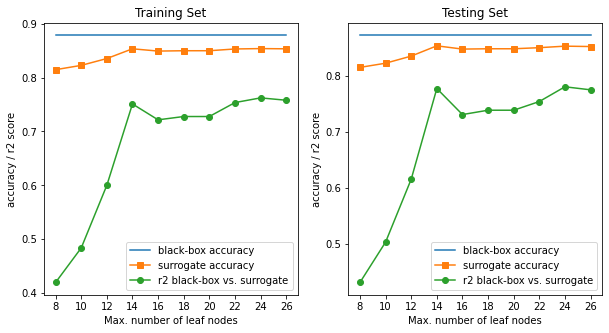

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig_labels = ['Training Set', 'Testing Set']
markers = [None, 's', 'o']
for i, dset in enumerate(['trn', 'tst']):
    for j, curve in enumerate(['black-box', 'surrogate', 'r2']):
        z = [acc[mleaf][dset][curve] for mleaf in leaf_limits]
        ax[i].plot(leaf_limits, z, marker=markers[j])
    ax[i].legend(['black-box accuracy', 'surrogate accuracy', 'r2 black-box vs. surrogate'])
    ax[i].set_title(fig_labels[i])
    ax[i].set_xlabel('Max. number of leaf nodes')
    ax[i].set_ylabel('accuracy / r2 score')
    ax[i].set_xticks(leaf_limits)
    
pngFile = './figures/CH09_F12_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)    

A decision-tree surrogate with 14 leaf nodes seems to achieve the ideal tradeoff between fidelity and complexity for explainability. The listing below trains a surrogate decision-tree model with these specifications.

**Listing 9.7.** Training a surrogate model

In [20]:
surrogate = DecisionTreeClassifier(max_leaf_nodes=14, criterion='gini', 
                                   min_samples_leaf=20, class_weight={0: 1, 1: 10})
surrogate.fit(Xtrn, yb_trn_pred)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_leaf_nodes=14,
                       min_samples_leaf=20)

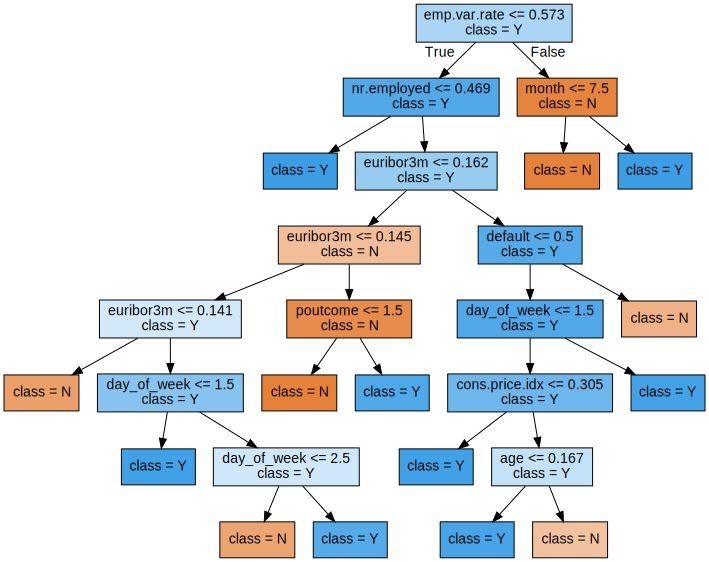

In [23]:
import graphviz, re, pydotplus
from sklearn import tree

features = Xtst.columns.to_numpy()
dot = tree.export_graphviz(surrogate, feature_names=features, # leaves_parallel=True,
                           class_names=['N', 'Y'],
                           filled=True, impurity=False)
dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])', '', dot)
dot = re.sub('(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
graphviz.Source(dot, format="png")

In [24]:
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('./figures/CH09_F13_Kunapuli.png');
# This image is further edited by hand 